In [1]:
import pandas as pd
from editdistance import distance
from openai import OpenAI
from datetime import datetime
import json
from dotenv import load_dotenv
import os

In [2]:
LOG_PATH = "logs/log-01.jsonl"

In [3]:
load_dotenv()
API_KEY = os.getenv("MY_API_KEY")
client = OpenAI(api_key=API_KEY)

In [4]:
PROMPT_TEMPLATES = {
    "template-001": "Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents in Estonian. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. The text to correct appears after the segment 'TEXT TO CORRECT:'. Please place the corrected version of the text after the 'CORRECTED TEXT:' segment. Do not write anything else than the corrected text.\n\n TEXT TO CORRECT:\n {ocr_transcription} \n CORRECTED TEXT:"
}

In [5]:
def lev_sim(transcription, GT):
    """Relative Levenhstein distance between any transcription and the ground truth."""
    length = max(len(transcription), len(GT))
    return (length - distance(transcription, GT)) / length

def pcis(orig_sim, llm_sim):
    """Post Correction Improvement Score based on the Levenhstein distance between the original transcription and the GT and between the LLM transcription and the GT."""
    if orig_sim == 0:
        return min(max(llm_sim, -1), 1)
    elif orig_sim != llm_sim:
        return min(max((llm_sim - orig_sim) / orig_sim, -1), 1)
    else:  # This means orig_sim == llm_sim
        return 0

In [6]:
class Experiment():
    def __init__(self, pageOID: str, OCR: str, GT: str,
                 model: str, template_id: str, system_message: str,
                 verbose: bool) -> None:
        self.pageID = pageOID
        self.OCR = OCR
        self.GT = GT
        self.model = model
        self.template_id = template_id
        self.prompt_template = PROMPT_TEMPLATES[template_id]
        self.system_message = system_message
        self.verbose = verbose

    def request_correction(self):
        if self.verbose == True:
            print(f"Fetching completion from {self.model}")
        messages = []
        if self.system_message:
            messages.append({"role": "system", "content": self.system_message})
        prompt = self.prompt_template.format(ocr_transcription=self.OCR)
        messages.append({"role": "user", "content": prompt})

        response = client.chat.completions.create(
            model=self.model,
            messages=messages
        )
        return response.choices[0].message.content
    
    def get_correction_pcis(self):
        """Retrieve the Post Correction Improvement Score based on the original transcription, the LLM transcription and the ground truth."""
        orig_sim = lev_sim(self.OCR, self.GT)
        llm_sim = lev_sim(self.LLM, self.GT)
        return pcis(orig_sim, llm_sim)
    
    def log_results(self):
        log_entry = {
            "experiment_id": self.ID,
            "timestamp": datetime.now().isoformat(),
            "model": self.model,
            "prompt_template": self.template_id,
            "system_message": self.system_message,
            "pageOID": self.pageID,
            "OCR": self.OCR,
            "GT": self.GT,
            "LLM": self.LLM,
            "PCIS": self.PCIS
            }

        with open(LOG_PATH, "a") as file:
            file.write(json.dumps(log_entry) + "\n")

    def run(self):
        try:
            last_experiment_ID = pd.read_json(LOG_PATH, lines=True).experiment_id.max()
        except:
            last_experiment_ID = -1
        self.ID = int(last_experiment_ID + 1)
        self.LLM = self.request_correction()
        self.PCIS = self.get_correction_pcis()
        self.log_results()


In [7]:
eval_data = pd.read_csv("data/evaluation/OCR_groundtruth.tsv", sep="\t", encoding="utf8")

In [8]:
eval_data

,pageOID,oldtext,newtext
0,eestipostimees18841114.1.3,Wäljamaalt. SsM Maalt» SM räägitakse mõni kord...,Wäljamaalt. Saksa maalt. Sääl räägitakse mõni ...
1,postimeesew19231229.1.2,Päewauudised. Naroowa weeuputuse suuruse ja ka...,Päewauudised. Naroowa weeuputuse suuruse ja ka...
2,wabamaa19310211.1.3,Onro&ommiinine tulekulil Risti oleolkus. Oleta...,Warahommikune tulekahi Risti alewikus. Oletata...
3,sakalaew19000613.1.2,Koorelahutaja kasu wäike põllumehe majapidamis...,Koorelahutaja kasu wäike põllumehe majapidamis...
4,paevalehtew19110901.2.2,Wiimane torm on meie laewa ja kalameestele arw...,Wiimane torm on meie laewa- ja kalameestele ar...
5,sakalaew19320227.2.2,Lahing vendade vahel OlustveresPeida reikioman...,Lahing vendade vahel Olustveres. Peldu veskiom...
6,kaja19200221-1.1.1,Eesti saadik Pusta Jtalia Välisministri jutul....,Eesti saadik Pusta Italia wälisministri jutul....
7,paevalehtew19170727.1.3,Kooli elu. Eesti keel Tallstma poeglaste kmmae...,Kooli elu. Eesti keel Tallinna poeglaste komme...
8,postimeesew19061003.1.1,Karskuse kongress »l. Teise püema töö hakkas p...,Karskuse kongress. III. Teise päewa töö hakkas...
9,postimeesew19250327.1.4,Kiriklikud sekeldused Põltsamaal. „Sina ei pea...,Kiriklikud sekeldused Põltsamaal. „Sina ei pea...


In [ ]:
for model in ["gpt-3.5-turbo", "gpt-3.5-turbo-1106", "gpt-4", "gpt-4-turbo-preview"]:
    for _, row in eval_data.iterrows():
        experiment = Experiment(pageOID=row.pageOID,
                                OCR = row.oldtext,
                                GT = row.newtext,
                                model=model,
                                template_id="template-001",
                                system_message=None,
                                verbose=True
                                )
        experiment.run()

In [9]:
log = pd.read_json("logs/log-01.jsonl", lines=True)

<Axes: title={'center': 'PCIS'}, xlabel='[model]'>

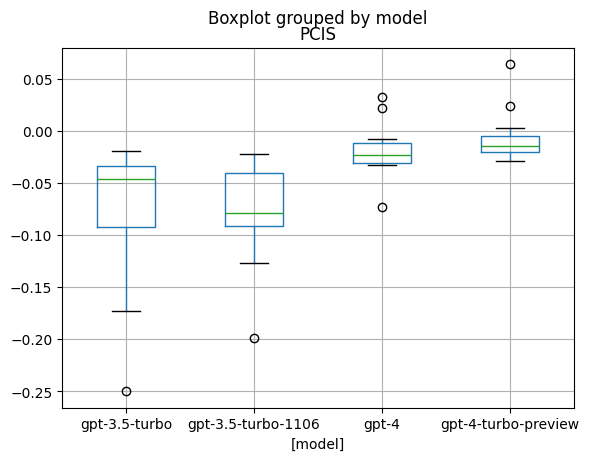

In [10]:
log[["model", "PCIS"]].boxplot(by="model")